<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/Lauren/Validation_Wrapper_LN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install CaImAn - takes around 2 minutes

!git clone https://github.com/flatironinstitute/CaImAn.git
%cd '/content/CaImAn/'
!pip install -e .

# Install caiman dependencies (&> /dev/null will suppress the hundreds of printed lines in the output)
!pip install -r requirements.txt &> /dev/null

#import other dependencies
import cv2
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio

#IMPORTANT! Newer versions of h5py will cause errors when saving results
!pip install h5py==2.10.0
import h5py

#Set up caiman
!python setup.py build_ext -i

#Other file setup
!python caimanmanager.py install --inplace

#Caiman imports
import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
from caiman.summary_images import local_correlations_movie_offline
from scipy.ndimage import center_of_mass
from IPython.display import display, clear_output

Cloning into 'CaImAn'...
remote: Enumerating objects: 24933, done.
remote: Counting objects: 100% (868/868), done.
remote: Compressing objects: 100% (432/432), done.
remote: Total 24933 (delta 481), reused 753 (delta 419), pack-reused 24065
Receiving objects: 100% (24933/24933), 518.57 MiB | 13.67 MiB/s, done.
Resolving deltas: 100% (16694/16694), done.
Checking out files: 100% (317/317), done.
/content/CaImAn
Obtaining file:///content/CaImAn
  Running setup.py develop for caiman
     |████████████████████████████████| 2.9 MB 3.5 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
running build_ext
Installed /root/caiman_data


## Get paths to movie files and labelled ROI masks

In [4]:
#get a list of our masks and a list of our stacks in the same order
from os import listdir
maskpath = '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs'
mask_filenames = [f for f in listdir(maskpath) if 'manualROIs' in f]
mask_filenames = sorted(mask_filenames)
mask_filenames

['210728_0_1_manualROIs_tm2_tm9_syt.mat',
 '210731_0_1_manualROIs_mix2_syt.mat',
 '210815_0_1_manualROIs_mix1_syt.mat',
 '211023_0_1_manualROIs_tm2_tm4_syt.mat',
 '211106_0_1_manualROIs_tm1_t5_syt.mat',
 '211106_1_1_manualROIs_tm4_t5_syt.mat']

In [5]:
stack_indices = [x[:10] for x in mask_filenames] #get the index portion of the masks
stack_celltypes = [x[22:(len(x)-4)] for x in mask_filenames] #get the cell type descriptions

#create filenames in mat and h5, well only keep what exists
stack_filenames_h5 = ['CLEAN_' + stack_indices[x] + '_stackRaw_mc_' + stack_celltypes[x] \
                   + '_.h5' for x in range(len(mask_filenames))] #reconstruct filenames for the movies we have masks for
stack_filenames_mat = ['CLEAN_' + stack_indices[x] + '_stackRaw_mc_' + stack_celltypes[x] \
                   + '_.mat' for x in range(len(mask_filenames))] #reconstruct filenames for the movies we have masks for
stack_filenames = stack_filenames_h5 + stack_filenames_mat 
stack_filenames

['CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5',
 'CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5',
 'CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.h5',
 'CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.h5',
 'CLEAN_211106_0_1_stackRaw_mc_tm1_t5_syt_.h5',
 'CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5',
 'CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.mat',
 'CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.mat',
 'CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.mat',
 'CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.mat',
 'CLEAN_211106_0_1_stackRaw_mc_tm1_t5_syt_.mat',
 'CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.mat']

In [6]:
#checking that files exist in our cleaned file
stackpath = '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED'
stackfiles = [f for f in listdir(stackpath) if f in stack_filenames]
stackfiles = sorted(stackfiles)
stackfiles

['CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5',
 'CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5',
 'CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.h5',
 'CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.h5',
 'CLEAN_211106_0_1_stackRaw_mc_tm1_t5_syt_.h5',
 'CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']

In [7]:
#convert filenames back into paths
maskpaths = [maskpath+'/'+f for f in mask_filenames]
stackpaths = [stackpath+'/'+f for f in stackfiles]

In [8]:
#join the lists into pairs of tuples
mask_stack_pairs = list(map(lambda x, y:[x,y], maskpaths, stackpaths))
mask_stack_pairs

[['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210731_0_1_manualROIs_mix2_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210815_0_1_manualROIs_mix1_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211023_0_1_manualROIs_tm2_tm4_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualRO

## Initialize parameters object with starter values

In [9]:
#create parameters object
opts = params.CNMFParams()
#fname will be assigned in the loop
fnames = []
subfolder = 'stackRaw_mc'

In [10]:
# set initial values for extraction and evaluation
# most of these are specific to our data and will not need to be changed during optimization

# overall params about our data

fr = 20                 # approximate frame rate of data - CONFIRMED FPS
decay_time = .4         # length of transient - CONFIRMED APPROPRIATE FOR OUR INDICATOR GCaMP6f
dims = [128, 256]       # dimensions of the FOV in pixels - CONFIRMED
dxy = [.29, .29]        # resolution of 1 pixel in um - CONFIRMED BY CARL

opts.set('data', {'fnames': fnames,
                   'fr': fr,
                   'decay_time': decay_time,
                   'dims': dims,
                   'dxy': dxy
                  })


# params related to the temporal traces

p = 1                   # order of the autoregressive system - 0 from carl's code, probably should be 1
fudge_factor = 1        # (default is 0.96; Carl's value = 1) -- bias correction factor for discrete time constants
ITER = 5                # (default is 2; Carl's value=5) -- block coordinate descent iterations
tnb = 2                  # temporal global background components - TUNE

opts.set('temporal', {'p': p,
                      'fudge_factor': fudge_factor,
                      'ITER': ITER,
                      'nb': tnb
                 })

# p is also set in the preprocessing step
opts.set('preprocess', {'p': p
                 })



# params related to the FOV and patches for parallel processing

is_patches = True      # flag for processing in patches or not - turn on or off

if is_patches:          # PROCESS IN PATCHES AND THEN COMBINE 
    rf = 25             # half size of each patch -not tuned
    stride = 5          # overlap between patches -not tuned
    K = 3               # number of components in each patch - TUNE - gets set later in INIT params
    p_patch = p

else:                   # PROCESS THE WHOLE FOV AT ONCE
    rf = None           # setting these parameters to None Not used
    stride = None       # will run CNMF on the whole FOV not used
    K = 20              # number of neurons expected (in the whole FOV) - not used

n_processes = 2         # Number of processes to run in parallel, 2 for 2 cores available in Colab

opts.set('patch', {'rf': rf,
                   'stride': stride,
                   'n_processes': n_processes,
                   'p_patch': p
                  })   



# initialization params
ssub = 2                # spatial downsampling
tsub = 2                # temporal downsampling
ssub_B = 3              # background spatial downsampling
gSig = [4,4]            # radius (half-size) of average neurons (in pixels)
nb = 2                  # number of background components

opts.set('init', {'K': K,            # declared above in patch params    
                   'gSig': gSig,      
                   'tsub': tsub,
                   'ssub': ssub,
                   'ssub_B': ssub_B,
                   'nb': nb
                  })

# parameters related to merging correlated ROIs
merge_thr = 0.9     # merging threshold, max correlation allowed - TUNE

opts.set('merging', {'merge_thr': merge_thr
                            })


#set some spatial params
snb = 2                  # spatial global background components - TUNE

opts.set('spatial', {'nb': snb
                            })

# %% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier (this will pick up only neurons
#           and filter out active processes)


#Not sure if these should be tuned or not

min_SNR = 2.5      # peak SNR for accepted components (if above this, acept)
SNR_lowest = 1         # minimum SNR for accepted components (if below this, reject)
rval_thr = 0.9     # space correlation threshold (if above this, accept)

use_cnn = False      # use the CNN classifier affects if 2 below params are used
min_cnn_thr = 0.9  # if cnn classifier predicts below this value, reject
cnn_lowest = 0.1   # neurons with cnn probability lower than this value are rejected

opts.set('quality', {'min_SNR': min_SNR,
                     'SNR_lowest': SNR_lowest,
                     'rval_thr': rval_thr,
                     'use_cnn': use_cnn,
                     'min_cnn_thr': min_cnn_thr,
                     'cnn_lowest': cnn_lowest})


#Manually assign subfolder variable
opts.motion['var_name_hdf5'] = subfolder
opts.data['var_name_hdf5'] = subfolder

## Define pipeline function to run Caiman

In [11]:
#Function to run cnmf, run seeded cnmf using masks, then return validation

def score_params(path_to_stack, path_to_masks, opts):
  import warnings
  warnings.simplefilter(action='ignore', category=FutureWarning)

  fnames = [path_to_stack]

  try:

    if 'dview' in locals():
      cm.stop_server(dview=dview)
    dview = cm.cluster.start_server(ncpus=2)

    #Run CNMF on raw stack using passed params
    #print('starting cnmf')
    cnm = cnmf.CNMF(n_processes = 2, params=opts, dview=dview)
    #print('cnm object initialized')
    cnm = cnm.fit_file(motion_correct = False, include_eval=True)
    #print('cnmf and component evaluation completed')


    #Read in masks and reformat
    g = h5py.File(path_to_masks, 'r')

    #transpose the matrix and save to an array A
    mask_A = g['bwMaskStack'][:].T

    g.close()

    #rearrange the dimensions and show the new shape
    mask_A = mask_A.transpose(1,0,2)

    #reshape to 2D, first dimension is 128*256 (32768), 2nd dimension is the # of ROI's
    mask_A = mask_A.reshape((mask_A.shape[1]*mask_A.shape[0]), mask_A.shape[2])

    #convert the values from 0/1 to boolean False/True
    mask_A = np.array(mask_A, dtype=bool)
    #print('mask read in and reformatted')

    #Seeded CNMF only works when seeded using mmap
    #import pathlib

    #read data from the original cnmf's mmap location
    Yr, dims, T = cm.load_memmap(cnm.mmap_file)

    # load frames in python format (T x X x Y)
    mov = np.reshape(Yr.T, [T] + list(dims), order='F')
    #print('movie matrix loaded for seeded cnmf')


    #For seeded CNMF, need to adjust some params
    opts.patch['only_init'] = False
    opts.data['use_cnn'] = False

    #print('params adjusted for seeded cnmf')
    
    #Initialize a new cnmf object and pass in our masks as the "Ain" param
    #"Ain" is A-in, meaning the A matrix holding the spatial footprints of the roi's
    cnm_seeded = cnmf.CNMF(n_processes = 2, params=opts, dview=None, Ain=mask_A)
    #print('seeded cnmf object initialized')
    cnm_seeded.fit(mov)
    #print('seeded cnmf completed')

    #Try running register_ROIs and see what happens
    matched_ROIs1, matched_ROIs2, non_matched1, non_matched2, performance, A2 = cm.base.rois.register_ROIs(cnm_seeded.estimates.A, cnm.estimates.A, dims=dims)
    #print('validation and scoring completed')

    #restore params for the next regular cnmf iteration
    opts.patch['only_init'] = True
    #opts.data['use_cnn'] = True

    cm.stop_server(dview=dview)


    #return performance metrics
    return {'matched_ROIs1': matched_ROIs1,
            'matched_ROIs2': matched_ROIs2,
            'non_matched1': non_matched1,
            'non_matched2': non_matched2, 
            'performance': performance,
            'A2': A2,
            'cnm_estimates': cnm.estimates,
            'seeded_cnm_estimates': cnm_seeded.estimates}

  except:
    print('failed')
    cm.stop_server(dview=dview)

## Function to score all our stacks and return the avg f1

In [12]:
#loop through the stack-mask pairs and print the accuracy results

def score_all_stacks(all_params):

  print(all_params)

  K = all_params[0]
  nb = all_params[1]
  merge_thresh = all_params[2]
  gSig = [all_params[3], all_params[4]] #param passes one value, recreate [x,y] structure
  SNR_lowest = all_params[5]


  from statistics import mean

  #hard coded paths since these won't change for now, proceduralize later
  mask_stack_pairs = [['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210731_0_1_manualROIs_mix2_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210815_0_1_manualROIs_mix1_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210815_0_1_stackRaw_mc_mix1_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211023_0_1_manualROIs_tm2_tm4_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211023_0_1_stackRaw_mc_tm2_tm4_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211106_0_1_manualROIs_tm1_t5_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_0_1_stackRaw_mc_tm1_t5_syt_.h5'],
 ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/211106_1_1_manualROIs_tm4_t5_syt.mat',
  '../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']]



  #Assign params passed in by the wrapper function
  opts.init['K'] = K
  opts.init['nb'] = nb #nb gets assigned in three different dicts
  opts.spatial['nb'] = nb
  opts.temporal['nb'] = nb
  opts.merging['merge_thresh'] = merge_thresh
  opts.init['gSig'] = gSig
  opts.quality['SNR_lowest'] = SNR_lowest

  #store precisions from each stack-mask pair for this iteration in a list, we'll return the average
  f1s = []

  #this loop will run all stacks through caiman using a given set of parameters to get the accuracy
  for pair in mask_stack_pairs:
    path_to_stack = pair[1]
    path_to_masks = pair[0]

    #set fnames before calling caiman function
    opts.data['fnames'] = [path_to_stack]
    print(opts.data['fnames'])

    results = score_params(path_to_stack=path_to_stack, \
              path_to_masks=path_to_masks, \
              opts=opts)
    
    #store this stack-mask pair's precision
    #later handle some kind of logging to keep a dict of info returned
    f1s.append(results['performance']['f1_score'])

    print(results['performance'])

  #return the mean precision for all mask-stack pairs
  #negative of the precision, so that the optimizer can minimize
  print(f1s)
  return -mean(f1s)



## Bayesian Model Optimization

In [13]:
!pip install scikit-optimize
import skopt
from skopt.callbacks import CheckpointSaver
from skopt.callbacks import DeltaYStopper
from skopt.callbacks import DeadlineStopper
from skopt import plots
from skopt import load

     |████████████████████████████████| 100 kB 1.4 MB/s 


In [14]:
# #load old checkpoints if we need - change path
# checkpoints = skopt.load('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/search_checkpoints2.pkl')

In [15]:
#define the parameter space - this is the entirety of the space I want to explore and will take a long time to run

#change params if needed
SPACE = [
        skopt.space.Integer(2, 25, name='K'), #number of ROIs to expect in the FOV
        skopt.space.Integer(1,3, name='nb'), #measure of how much background noise to remove, minimum 2 but higher could remove ROIs
        skopt.space.Real(.8, .9999, name= 'merge_thresh'), #how correlated ROIs need to be before they get merged
        skopt.space.Integer(1, 10, name = 'gSig_wid'), #half-width of neurons - Supposedly the most important
        skopt.space.Integer(1, 10, name = 'gSig_hei'), #half-height of neurons - Supposedly the most important
        skopt.space.Real(.75, 2.25, name = 'SNR_lowest')] #Minimum SNR accepted for ROIs, (if below this, reject)

In [16]:
#saves a checkpoint every iteration to this filepath

#CHANGE THIS PATH OR FILENAME BEFORE YOU RUN THIS - LEAVE THE EXTENSION AS .PKL
# 6 best / most complete thus far
# -0.1449
# (2, 25) K
# (1,3) nb
# (.8, .9999)
# (1,10)
# (1,10)
# (0.75, 2.25)

checkpoint_saver = CheckpointSaver('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/search_checkpoints_ln_attempt_7.pkl')

#stopping criteria - stop if the 5 best iterations are within 3% of each other- might want to make more strict
stopping_criteria = skopt.callbacks.DeltaYStopper(.01, n_best=5)

#second criteria, stop after 11.5 hours if it hasn't stopped yet - takes time in seconds as argument
mins = 11.5 * 60
seconds = mins * 60
stopping_criteria_2 = DeadlineStopper(total_time= seconds)


# surrogate function, directly pass in parameter list, returns precision result directly
#this is the function that the optimizer minimizes
#score_all_stacks returns the precision * -1 so that the optimizer can minimize it
def objective(parameters):
    return score_all_stacks(parameters)

In [17]:
# #load old checkpoints if we need - change path
checkpoints = skopt.load('../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/search_checkpoints_ln_attempt_6.pkl')
x0 = checkpoints.x_iters
y0 = checkpoints.func_vals

In [18]:
#optimizer using objective function, parameter space, checkpointer, stopping criteria

#change minimizer function if needed
results = skopt.gp_minimize(objective, 
                              SPACE,
                              x0=x0,     # already examined values for x from checkpoints
                              y0=y0,     # observed values for x0 from checkpoints 
                              callback=[checkpoint_saver, stopping_criteria, stopping_criteria_2], 
                              initial_point_generator = 'halton',
                              n_jobs = 2,
                              verbose=True)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0165
Function value obtained: -0.1501
Current minimum: -0.1508
Iteration No: 2 started. Evaluating function at random point.
[11, 2, 0.9119440000000001, 3, 1, 1.797337278106509]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
............spatial support for each components given by the user
{'recall': 0.5, 'precision': 0.0410958904109589, 'accuracy': 0.039473684210526314, 'f1_score': 0.0759493670886076}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210731_0_1_stackRaw_mc_mix2_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
............spatial support for each components given by the user
{'recall': 0.0, 'pre

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
............spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
[0.0759493670886076, 0.0, 0.07692307692307693, 0.0, 0.0, 0.0]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 979.7665
Function value obtained: -0.0255
Current minimum: -0.1508
Iteration No: 3 started. Evaluating function at random point.
[23, 3, 0.951924, 4, 2, 1.9127218934911243]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
............

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
..................spatial support for each components given by the user
{'recall': 0.6, 'precision': 0.13043478260869565, 'accuracy': 0.12, 'f1_score': 0.21428571428571427}
[0.17142857142857143, 0.0, 0.10526315789473684, 0.0, 0.0, 0.21428571428571427]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1051.7265
Function value obtained: -0.0818
Current minimum: -0.1508
Iteration No: 4 started. Evaluating function at random point.
[4, 2, 0.991904, 5, 3, 2.02810650887574]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for connection file: ~/.ipython/profile_

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
...................spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
[0.125, 0.0, 0.10526315789473684, 0.0, 0.0, 0.0]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 686.9448
Function value obtained: -0.0384
Current minimum: -0.1508
Iteration No: 5 started. Evaluating function at random point.
[16, 2, 0.8015992000000001, 7, 4, 2.143491124260355]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
.........

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
..................spatial support for each components given by the user
{'recall': 0.2, 'precision': 0.0625, 'accuracy': 0.05, 'f1_score': 0.09523809523809523}
[0.14285714285714285, 0.08695652173913043, 0.12903225806451613, 0.07407407407407407, 0.0, 0.09523809523809523]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 850.1827
Function value obtained: -0.0880
Current minimum: -0.1508
Iteration No: 6 started. Evaluating function at random point.
[10, 3, 0.8415792000000001, 8, 4, 0.7677514792899408]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for conne

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
..................spatial support for each components given by the user
{'recall': 0.2, 'precision': 0.1, 'accuracy': 0.07142857142857142, 'f1_score': 0.13333333333333333}
[0.09090909090909091, 0.0, 0.08, 0.0, 0.0, 0.13333333333333333]
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 843.8066
Function value obtained: -0.0507
Current minimum: -0.1508
Iteration No: 7 started. Evaluating function at random point.
[21, 1, 0.8815592000000001, 9, 5, 0.8831360946745562]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for connection file: ~/.ipython/profile_defa

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
...................spatial support for each components given by the user
{'recall': 0.6, 'precision': 0.14285714285714285, 'accuracy': 0.13043478260869565, 'f1_score': 0.23076923076923078}
[0.18181818181818182, 0.07142857142857142, 0.1111111111111111, 0.0625, 0.0, 0.23076923076923078]
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 814.1920
Function value obtained: -0.1096
Current minimum: -0.1508
Iteration No: 8 started. Evaluating function at random point.
[7, 2, 0.9215392, 2, 6, 0.9985207100591716]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for 

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
..................spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
[0.21052631578947367, 0.0, 0.09090909090909091, 0.0, 0.0, 0.0]
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 784.7114
Function value obtained: -0.0502
Current minimum: -0.1508
Iteration No: 9 started. Evaluating function at random point.
[19, 2, 0.9615192, 3, 7, 1.113905325443787]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
.....

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
...................spatial support for each components given by the user
{'recall': 0.4, 'precision': 0.10526315789473684, 'accuracy': 0.09090909090909091, 'f1_score': 0.16666666666666666}
[0.12903225806451613, 0.08, 0.11764705882352941, 0.06666666666666667, 0.0, 0.16666666666666666]
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 910.4429
Function value obtained: -0.0933
Current minimum: -0.1508
Iteration No: 10 started. Evaluating function at random point.
[13, 1, 0.8095952000000001, 4, 8, 1.2292899408284024]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Wa

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
...................spatial support for each components given by the user
{'recall': 0.2, 'precision': 0.07692307692307693, 'accuracy': 0.058823529411764705, 'f1_score': 0.1111111111111111}
[0.16, 0.1, 0.14814814814814814, 0.08333333333333333, 0.0, 0.1111111111111111]
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 750.1519
Function value obtained: -0.1004
Current minimum: -0.1508
Iteration No: 11 started. Evaluating function at random point.
[24, 2, 0.8495752000000001, 6, 9, 1.3446745562130178]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for connec

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
...................spatial support for each components given by the user
{'recall': 0.6, 'precision': 0.125, 'accuracy': 0.11538461538461539, 'f1_score': 0.20689655172413793}
[0.1111111111111111, 0.06451612903225806, 0.10526315789473684, 0.05714285714285714, 0.0, 0.20689655172413793]
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 1065.3148
Function value obtained: -0.0908
Current minimum: -0.1508
Iteration No: 12 started. Evaluating function at random point.
[25, 1, 0.8, 10, 10, 0.75]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for connection file

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
...................spatial support for each components given by the user
{'recall': 0.6, 'precision': 0.12, 'accuracy': 0.1111111111111111, 'f1_score': 0.2}
[0.2702702702702703, 0.0625, 0.20512820512820512, 0.16666666666666666, 0.0, 0.2]
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 889.7151
Function value obtained: -0.1508
Current minimum: -0.1508
Iteration No: 13 started. Evaluating function at random point.
[25, 1, 0.9999, 10, 10, 0.75]
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontr

/content/CaImAn/caiman/summary_images.py:217: RuntimeWarning: invalid value encountered in true_divide
  w_mov = (Y - np.mean(Y, axis=0)) / np.std(Y, axis=0)


....spatial support for each components given by the user
{'recall': 0.0, 'precision': 0.0, 'accuracy': 0.0, 'f1_score': 0.0}
['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_211106_1_1_stackRaw_mc_tm4_t5_syt_.h5']
Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
...................spatial support for each components given by the user
{'recall': 0.6, 'precision': 0.12, 'accuracy': 0.1111111111111111, 'f1_score': 0.2}
[0.2702702702702703, 0.0625, 0.20512820512820512, 0.16666666666666666, 0.0, 0.2]
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 892.9376
Function value obtained: -0.1508
Current minimum: -0.1508
Iteration No: 14 started. Evaluating function at random point.


In [19]:
results

          fun: -0.150760857010857
    func_vals: array([-0.01960784, -0.04995579, -0.05680045, -0.114328  , -0.08921569,
       -0.08802635, -0.11247036, -0.09427074, -0.01851852, -0.10513907,
       -0.12812322, -0.11839643, -0.04761905, -0.14492949, -0.11194319,
       -0.07331434, -0.10297932, -0.11194319, -0.08802635, -0.10688501,
       -0.15076086, -0.15008832, -0.02547874, -0.08182957, -0.03837719,
       -0.08802635, -0.05070707, -0.10960452, -0.05023923, -0.09333544,
       -0.1004321 , -0.09082163, -0.15076086, -0.15076086])
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
                         normalize_y=True, random_state=211311463), GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, noise='gaussian',
       

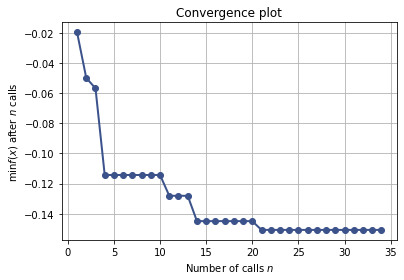

In [20]:
skopt.plots.plot_convergence(results)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcaf62a39d0>,
      dtype=object)

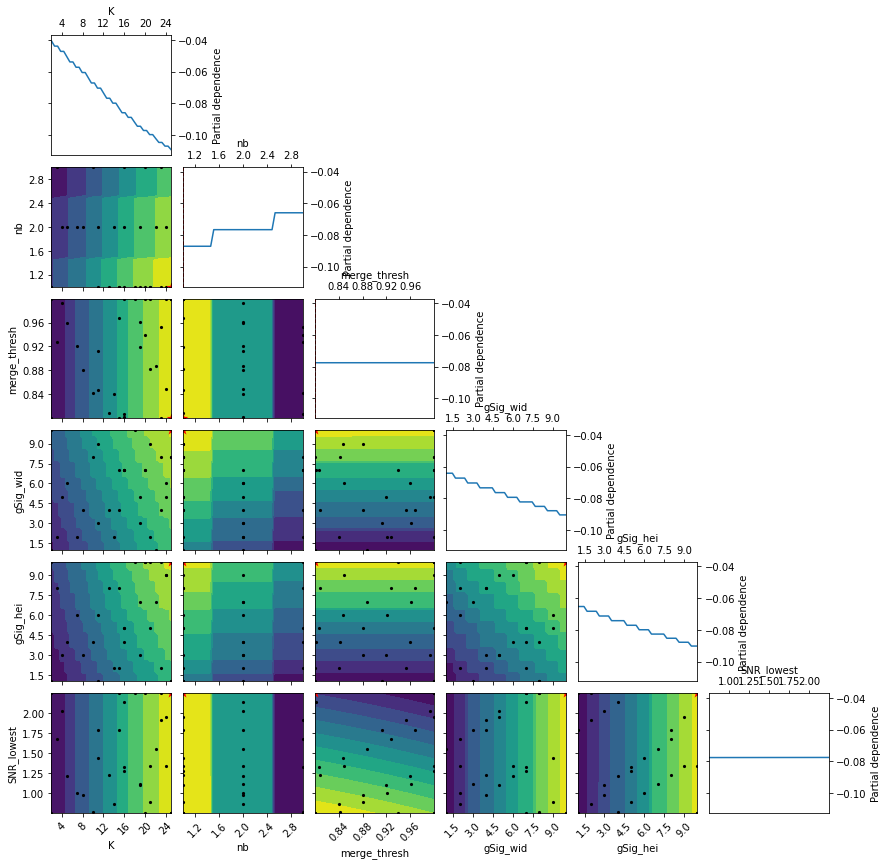

In [21]:
skopt.plots.plot_objective(results)

## Old working code

In [22]:
# #tests score_all_stacks directly
# dummy_in = [13, 2, 0.9, 5, 10, .8]
# score_all_stacks(dummy_in)

In [23]:
# #tests score_params directly
# opts.data['fnames'] = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.mat']
# score_params(path_to_masks='../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat', \
#               path_to_stack='../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.mat', \
#               opts=opts)

In [24]:
# #tests cnm directly
# opts.quality['use_cnn'] = True
# opts.data['fnames'] = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.mat']

# if 'dview' in locals():
#     cm.stop_server(dview=dview)
# dview = cm.cluster.start_server(ncpus=2)
# cnm = cnmf.CNMF(n_processes=2, params=opts, dview=dview)
# #print('cnm object initialized')
# cnm = cnm.fit_file(motion_correct = False, include_eval=True)
# cm.stop_server(dview=dview)

# cnm.estimates.A

In [25]:
# #tests masks and scoring directly 
# fnames = ['../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/stackRaw/CLEANED/CLEAN_210728_0_1_stackRaw_mc_tm2_tm9_syt_.h5']
# path_to_masks='../drive/MyDrive/DS6011_Capstone_VisualNeuroscience/DATA/manualROIs/210728_0_1_manualROIs_tm2_tm9_syt.mat'
# #Read in masks and reformat
# g = h5py.File(path_to_masks, 'r')

# #transpose the matrix and save to an array A
# mask_A = g['bwMaskStack'][:].T

# g.close()

# #rearrange the dimensions and show the new shape
# mask_A = mask_A.transpose(1,0,2)

# #reshape to 2D, first dimension is 128*256 (32768), 2nd dimension is the # of ROI's
# mask_A = mask_A.reshape((mask_A.shape[1]*mask_A.shape[0]), mask_A.shape[2])

# #convert the values from 0/1 to boolean False/True
# mask_A = np.array(mask_A, dtype=bool)
# #print('mask read in and reformatted')

# if 'dview' in locals():
#     cm.stop_server(dview=dview)
# dview = cm.cluster.start_server(ncpus=2)

# #Seeded CNMF only works when seeded using mmap
# #import pathlib

# #create memmory map location for the original movie
# #fname_new = cm.save_memmap(fnames, base_name=pathlib.Path(fnames[0]).stem + "_memmap_", order='C')

# #read data from mmap location
# Yr, dims, T = cm.load_memmap(cnm.mmap_file)

# # load frames in python format (T x X x Y)
# mov = np.reshape(Yr.T, [T] + list(dims), order='F')
# #print('movie matrix loaded for seeded cnmf')


# #For seeded CNMF, need to adjust some params
# opts.patch['only_init'] = False
# opts.patch['rf'] = None
# opts.data['use_cnn'] = False

# #print('params adjusted for seeded cnmf')
    
# #Initialize a new cnmf object and pass in our masks as the "Ain" param
# #"Ain" is A-in, meaning the A matrix holding the spatial footprints of the roi's
# cnm_seeded = cnmf.CNMF(n_processes = 2, params=opts, dview=None, Ain=mask_A)
# #print('seeded cnmf object initialized')
# cnm_seeded.fit(mov)
# #print('seeded cnmf completed')

# #Try running register_ROIs and see what happens
# matched_ROIs1, matched_ROIs2, non_matched1, non_matched2, performance, A2 = cm.base.rois.register_ROIs(cnm_seeded.estimates.A, cnm.estimates.A, dims=dims)
# #print('validation and scoring completed')

# performance